In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import warnings
warnings.filterwarnings('ignore')

import zipfile
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score


In [75]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


In [76]:
!kaggle datasets download ealaxi/paysim1

Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
paysim1.zip: Skipping, found more recently modified local copy (use --force to force download)


In [77]:
zip_path = "/content/paysim1.zip"


# Open and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extracts all files
    print("Extraction complete!")


Extraction complete!


In [78]:
transactions = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

In [79]:
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [80]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


#### Data Overview

- The dataset contains numerical fields (amount, oldbalanceOrg) and categorical fields (type, nameOrig).
- The step field represents the number of hours elapsed in the simulation.
- The dataset tracks original and new balances for transaction originators and recipients.

#### Fraud-Related Fields

- isFraud: Indicates whether a transaction is fraudulent (ground truth).
- isFlaggedFraud: Flags transactions above a certain amount (200,000), acting as a simple hard-coded fraud detection rule.

#### Modeling Decision

- The isFraud column will be used for evaluating fraud detection models.
- The isFlaggedFraud column will serve as a baseline rule, which the ML model should ideally improve upon.
- **The goal is to develop an anomaly detection model that detects fraud without prior knowledge of fraudulent transactions.**

#### Selecting Numerical Features

In [81]:
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

#### Creating a New DataFrame for Features

In [82]:
features = pd.DataFrame(index=transactions.index) # keeps the same index as the transactions DataFrame.
features[numerical_columns] = transactions[numerical_columns] #Copying Numerical Columns to the Features DataFrame

#### Creating Balance Change Features

- The amount field represents the transaction amount, but it does not always match the difference between original and new balances.
- To capture the actual balance change, two new features are created:
- **changebalanceOrig →** Measures the difference in balance for the originating account.
- **changebalanceDest →** Measures the difference in balance for the destination account.

In [83]:
features['changebalanceOrig'] = features['newbalanceOrig'] - features['oldbalanceOrg']
features['changebalanceDest'] = features['newbalanceDest'] - features['newbalanceOrig']

#### Extracting the Hour of the Day from Step Field

#### What does this do?

- The step field represents the number of hours since the beginning of the dataset.
- To find the hour of the day when the transaction occurred, we use the modulo operation (% 24):
Example: If step = 26, then 26 % 24 = 2, meaning the transaction occurred at 2 AM.
#### Why is this important?

- Fraudulent transactions often happen at unusual hours, such as late at night when users are inactive.
- The model can use this feature to detect patterns in fraudulent activity.

In [84]:
features['hour'] = transactions['step'] % 24

#### One-Hot Encoding the ‘type’ Column

- The type column represents the transaction type and can take five possible values:

CASH-IN,
CASH-OUT,
DEBIT,
PAYMENT,
TRANSFER.
- Since there is no natural order among these categories, we use one-hot encoding to convert them into numerical form.

In [85]:
type_one_hot = pd.get_dummies(transactions['type'])
features = pd.concat([features, type_one_hot], axis=1)

## Isolation Forest for Fraud Detection – Intuition and Explanation
#### Isolation Forest (IF) is an unsupervised anomaly detection algorithm that identifies fraud by isolating rare and different transactions in a dataset. It satisfies the requirements for a general fraud detection system:

- No assumptions about anomalies – It does not need predefined fraud patterns.
- No labeled data required – Works without the isFraud column.
- Provides an anomaly score – Transactions are ranked by how "anomalous" they are.

### Model Training

In [86]:
# Initialize Isolation Forest
forest = IsolationForest(random_state=0)

# Train the model on selected features
forest.fit(features)
# It does not require fraud labels (isFraud column), making it an unsupervised method.
# We set random_state=0 for reproducibility.

IsolationForest(random_state=0)

### Generating Anomaly Scores

#### What does this do?

- Instead of a binary anomaly label (-1 for fraud, 1 for normal), we get a continuous anomaly score.
- Higher scores → More likely normal.
- Lower scores → More likely an anomaly (potential fraud).
- This is useful because we don't need to pick a fixed threshold—we can adjust it dynamically based on business needs.

In [87]:
# Get anomaly scores for each transaction
scores = forest.score_samples(features)

### Explanation of the Results and Evaluation Approach
- This fraud detection model using Isolation Forest produces continuous anomaly scores, meaning it does not directly classify transactions as fraudulent or non-fraudulent.
- Instead, we have to choose a threshold to separate anomalies from normal transactions.

### Visualizing Anomaly Scores
- Since Isolation Forest provides a continuous anomaly score, plotting its distribution helps in understanding where to set the threshold.

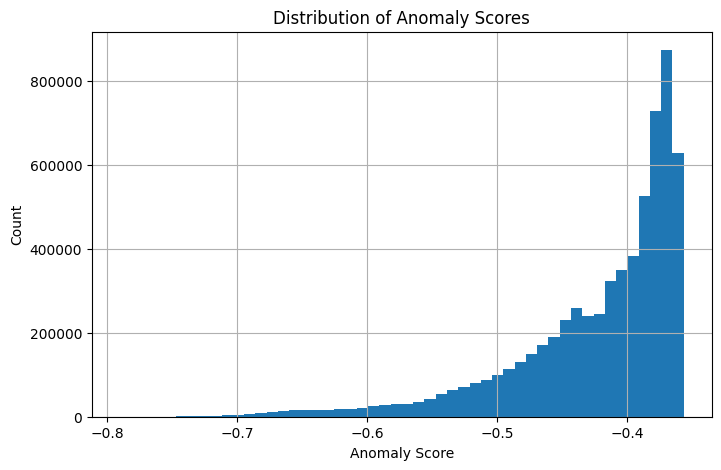

In [88]:
scores_df = pd.DataFrame(scores, columns=['Anomaly Score'])

# Plot histogram
scores_df.hist(bins=50, figsize=(8,5))
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.title('Distribution of Anomaly Scores')
plt.show()

### Evaluating Model Performance with ROC Curve
Since we have ground truth fraud labels (isFraud), we can use the ROC-AUC (Receiver Operating Characteristic - Area Under Curve) to measure how well the model distinguishes between fraud and non-fraud cases.

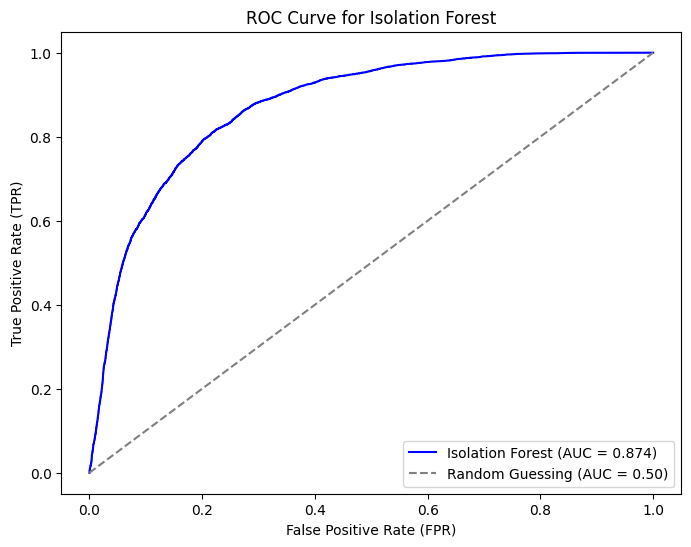

In [89]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(transactions['isFraud'], -scores)  # Negative scores since lower means more anomalous
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Isolation Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing (AUC = 0.50)")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Isolation Forest')
plt.legend()
plt.show()


# Higher AUC (~1.0) → Model is good at distinguishing fraud.
# AUC = 0.5 → Model performs like random guessing (bad).
# Lower AUC (< 0.5) → Model is worse than random (unlikely).


### Comparing with a Naive Baseline (isFlaggedFraud)
- To compare Isolation Forest with a naive approach, use amount as the anomaly score (since high values could indicate fraud).

#### Interpretation

- If Isolation Forest’s AUC > Naive Baseline’s AUC, it means our model is better than just flagging high-value transactions.
- If they are similar, then the model is not adding much improvement.
- If AUC is low, the model may not be learning fraud patterns effectively.

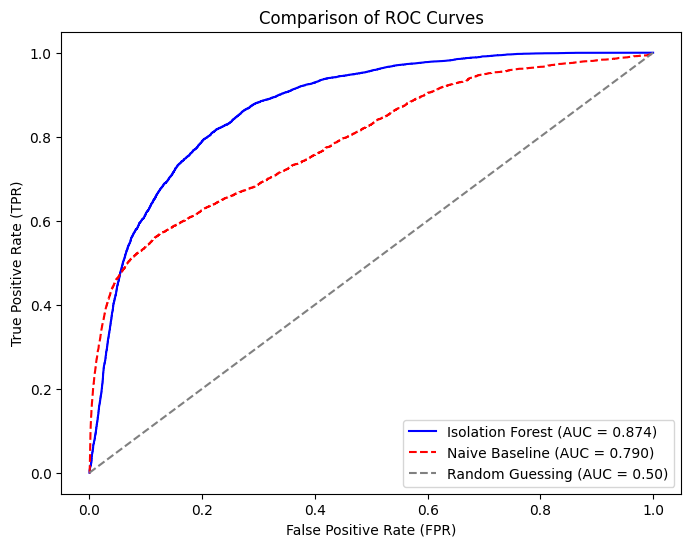

In [90]:
# Compute ROC for naive baseline (using 'amount' as the fraud indicator)
fpr_naive, tpr_naive, _ = roc_curve(transactions['isFraud'], transactions['amount'])
roc_auc_naive = auc(fpr_naive, tpr_naive)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Isolation Forest (AUC = {roc_auc:.3f})')
plt.plot(fpr_naive, tpr_naive, color='red', linestyle='--', label=f'Naive Baseline (AUC = {roc_auc_naive:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guessing (AUC = 0.50)")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Comparison of ROC Curves')
plt.legend()
plt.show()


## Identifying Top Anomalies
#### The Isolation Forest model provides a continuous anomaly score for each transaction, allowing us to flexibly determine fraudulent activities based on different threshold levels.

####To analyze the most suspicious transactions, we sort the dataset based on the anomaly scores and extract the top 5 anomalies—the transactions with the lowest anomaly scores, as they are considered the most anomalous by the model.

#### This analysis helps us prioritize the most critical fraud cases, making it easier for fraud analysts to investigate potential fraudulent activities. The next step involves interpreting why these specific transactions were flagged as anomalies, which can aid in refining fraud detection strategies.

In [91]:
# Get the top 5 anomalies (lowest scores indicate most anomalous)
features["anomaly_score"] = forest.score_samples(features)
top_anomalies = features.nsmallest(5, "anomaly_score")

# Display results
# print(top_anomalies)


In [92]:
top_anomalies

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,changebalanceOrig,changebalanceDest,hour,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,anomaly_score
5746685,1379094.53,22268807.63,23647902.16,69906476.09,6.852738e+07,1379094.53,4.487948e+07,15,True,False,False,False,False,-0.790214
4157895,37387628.10,862621.88,0.00,37843025.59,7.523065e+07,-862621.88,7.523065e+07,15,False,False,False,False,True,-0.778538
5980329,305789.07,22883607.03,23189396.10,77271760.10,7.696597e+07,305789.07,5.377657e+07,0,True,False,False,False,False,-0.777266
4136960,29802113.19,550210.01,0.00,48574467.89,1.542623e+08,-550210.01,1.542623e+08,15,False,False,False,False,True,-0.775384
4142016,51141938.17,310058.79,0.00,87081824.45,1.382238e+08,-310058.79,1.382238e+08,15,False,False,False,False,True,-0.774860


### Using .score_samples() with a Custom Threshold

In [93]:
# Get anomaly scores
# scores = forest.score_samples(features)

# Define a threshold (e.g., lowest 1% scores as anomalies)
threshold = np.percentile(scores, 1)

# Get indices of anomalies
anomaly_indices = np.where(scores < threshold)[0]

# Extract anomaly records from the original dataset
anomalous_records = transactions.iloc[anomaly_indices]

# Display top 3 anomalies
anomalous_records.head(3)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
358,1,TRANSFER,1538200.39,C476579021,0.0,0.0,C1590550415,6977445.38,19169204.93,0,0
359,1,TRANSFER,2421578.09,C106297322,0.0,0.0,C1590550415,8515645.77,19169204.93,0,0
362,1,TRANSFER,1457213.54,C396918327,0.0,0.0,C1590550415,10937223.86,19169204.93,0,0


### fit and predict Approach (Binary Classification)
- When using forest.predict(features), Isolation Forest classifies records as either normal (1) or anomalous (-1).
- The issue here is that the model applies an internal threshold automatically, which might not be optimal for your specific case.

### score_samples Approach (Better for Fine-Tuning)
- With forest.score_samples(features), you get continuous anomaly scores.
- Lower scores indicate higher likelihood of being an anomaly.

- By using np.percentile(), you can define a custom threshold based on the lowest-scoring data points (e.g., the bottom 1%).

In [94]:
# https://unit8.com/resources/a-guide-to-building-a-financial-transaction-anomaly-detector/?utm_source=chatgpt.com